In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.interpolate
import pycbc.types # TimeSeries
import pycbc.filter
import pycbc.psd

__init__: Setting weave cache to /usr1/bdlackey/1625_python27_compiled/f3c99c/f3c99c967caf7235ed2c95ee4846f4286aeb361b


In [3]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.6.0
HDF5    1.8.17
Python  2.7.5 (default, Sep 14 2016, 10:12:39) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-4)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.11.2



In [4]:
sys.path.insert(0, '../cbcrom')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)

<module 'chebyshev' from '../cbcrom/chebyshev.pyc'>

In [5]:
# Use the exact same units as LAL
G_SI = 6.67384e-11
C_SI = 299792458.0
MPC_SI = 3.085677581491367e+22
MSUN_SI = 1.9885469549614615e+30

In [6]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })


class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in xrange(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

# Load ROM

In [7]:
memb_size=2**26-1

# Bamp_filename = '../data/Bamp_cheb_3_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_3_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_3.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_3.hdf5'

# Bamp_filename = '../data/Bamp_cheb_9_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_9_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_9.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_9.hdf5'

Bamp_filename = '../data/Bamp_cheb_16_%d.hdf5'
Bphase_filename = '../data/Bphase_cheb_16_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs_cheb_16.hdf5'
phasecoeff_filename = '../data/phase_coeffs_cheb_16.hdf5'

rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

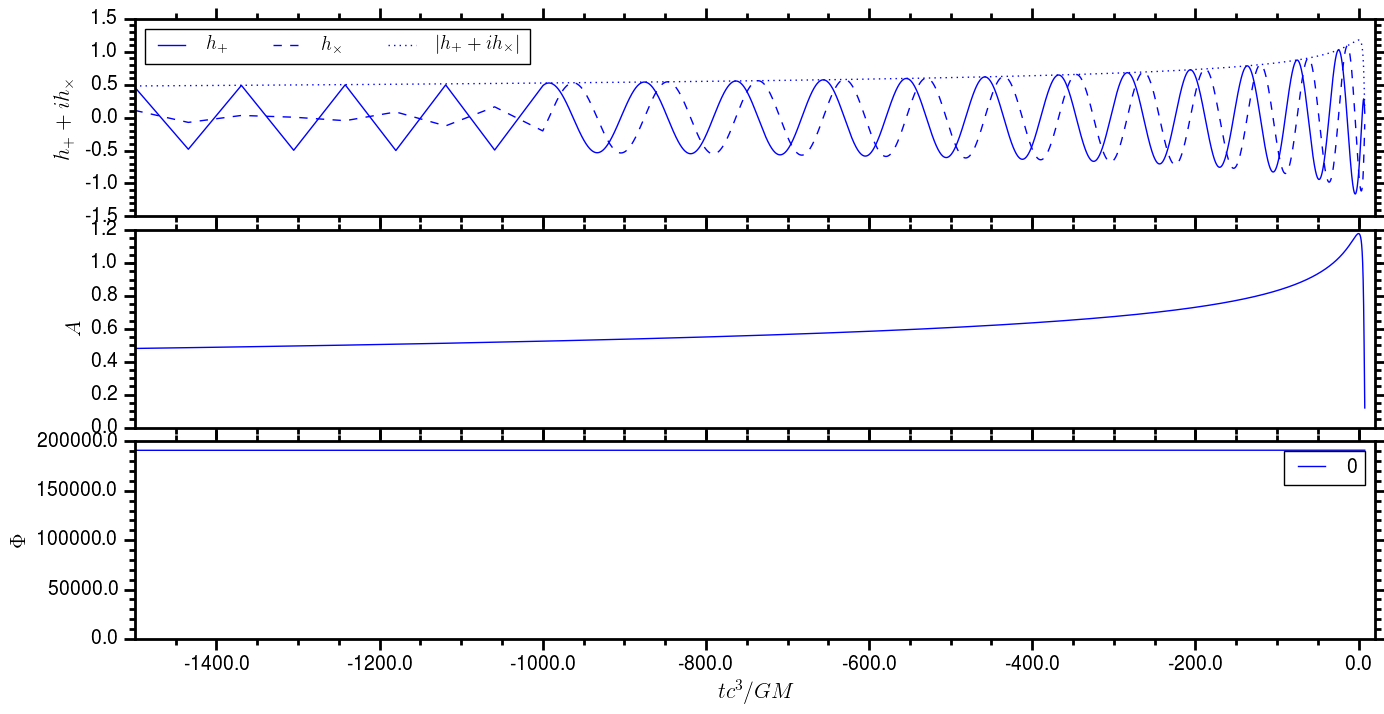

In [8]:
params = [1.0, 50.0, 50.0]
waveforms = rom.evaluate(params)

xlim=[-1500, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

# Load Test waveforms

In [9]:
filename = '../training_set_rand/teob_runs_rand_%d.hdf5'
memb_size=2**34-1
ts_rand = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

# Functions for calculating match

In [10]:
def reduced_order_model_time_series(rom, **kwargs):
    """Convert to pycbc TimeSeries.
    """
    tstart, delta_t, hp, hc = rom.evaluate_physical_units(**kwargs)
    hplus = pycbc.types.TimeSeries(hp, epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(hc, epoch=tstart, delta_t=delta_t)
    return hplus, hcross

In [11]:
def convert_to_physical_units(h, q=None, mass2=None,
                              delta_t=None, f_lower=None, f_ref=None, 
                              distance=None, inclination=None, coa_phase=None):
    """Construct a waveform with pycbc units from a ROM with dimensionless units.
    
    Parameters
    ----------
    q : float
        Mass ration q = mass2/mass1 <= 1
    mass2 :
        The mass of the second component object in the binary in solar masses.
    delta_t :
        The time step used to generate the waveform.
    f_lower :
        The starting frequency of the waveform.
    f_ref : {float}, optional
        The reference frequency
    distance : {1, float}, optional
        The distance from the observer to the source in megaparsecs.
    inclination : {0, float}, optional
        The inclination angle of the source.
    coa_phase : {0, float}, optional
        The final phase or phase at the peak of the wavform. See documentation
        on specific approximants for exact usage.
    lambda1: {0, float}, optional
        The tidal deformability parameter of object 1.
    lambda2: {0, float}, optional
        The tidal deformability parameter of object 2.
    
    Returns
    -------
    tstart : float
    delta_t : float
    hplus : array
    hcross : array
    """
    ################ Checking for correct input ################
    if f_lower < 10.0 or f_lower>700.0: raise ValueError('f_lower must be in range [11, 700]Hz')
    
    # Swap (mass1, mass2) if mass1 is not the larger mass
    #if mass1 < mass2:
    #    mass1, mass2 = mass2, mass1
        
    if q > 1.0: raise Exception, 'q must be <= 1.'
    
    ########## Constructing resampled waveform with physical units #########
    
    mass1 = mass2/q
    # Get times in seconds
    mtot = (mass1+mass2)*MSUN_SI
    time_phys = h.time*G_SI*mtot/C_SI**3
    eta = mass1*mass2/(mass1+mass2)**2

    order = 3
    ampoft = scipy.interpolate.UnivariateSpline(time_phys, h.amp, k=order, s=0)
    phaseoft = scipy.interpolate.UnivariateSpline(time_phys, h.phase, k=order, s=0)
    omegaoft = phaseoft.derivative(n=1)
    freq = omegaoft(time_phys)/(2*np.pi)
    #print freq[0], freq[-1]
    
    # Find region where frequency is monotonically increasing, then construct t(f)
    i_end_mono = next( (i for i in range(len(freq)-1) if freq[i]>=freq[i+1]), (len(freq)-1) )
    toffreq = scipy.interpolate.UnivariateSpline(freq[:i_end_mono], time_phys[:i_end_mono], k=order, s=0)
    
    # Resample with even spacing
    tstart = toffreq([f_lower])[0]
    time_phys_res = np.arange(tstart, time_phys[-1], delta_t)
    amp_res = ampoft(time_phys_res)
    phase_res = phaseoft(time_phys_res)
    #print phase_res
    #print phase_res[0]
    # Zero the phase at the beginning
    phase_res -= phase_res[0]
    
    # Rescale amplitude
    h22_to_h = 4.0*eta*np.sqrt(5.0/np.pi)/8.0
    amp_units = G_SI*mtot/(C_SI**2*distance*MPC_SI)
    amp_rescale = amp_units*h22_to_h*amp_res

    # Adjust for inclination angle [0, pi]
    inc_plus = (1.0+np.cos(inclination)**2)/2.0
    inc_cross = np.cos(inclination)
    
    hplus = inc_plus*amp_rescale*np.cos(phase_res)
    hcross = inc_cross*amp_rescale*np.sin(phase_res)
    
    hplus_ts = pycbc.types.TimeSeries(hplus, epoch=tstart, delta_t=delta_t)
    hcross_ts = pycbc.types.TimeSeries(hcross, epoch=tstart, delta_t=delta_t)
    return hplus_ts, hcross_ts

In [12]:
def mismatch(h1, h2, f_min):
    """
    """
    # Resize the waveforms so they both have the same length and make sure the length is even for use with PSD
    Nmax = max(len(h1), len(h2))
    if (Nmax%2 != 0):
        Nmax += 1
    h1.resize(Nmax)
    h2.resize(Nmax)
    
    # Generate the frequency series for the PSD
    delta_f = 1.0/(Nmax*delta_t)
    flen = Nmax/2 + 1
    #psd = pycbc.psd.from_txt(psd_file, flen, delta_f, f_min)
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    
    # Mismatch
    return 1.0-pycbc.filter.match(h1, h2, psd=psd, low_frequency_cutoff=f_min)[0]

In [13]:
def rom_mismatch(i, f_lower, fmatch_lower, delta_t, mass2):
    """
    """
    # Get true waveform
    htrue = ts_rand.get_waveform_data(i)
    
    # Get parameter values and waveform from training_set_rand
    params = ts_rand.get_waveform_data(i, data='parameters')
    q = params[0]
    #print q
    
    # Get ROM waveform
    hrom = rom.evaluate(params)
    
    distance, inclination = 100.0, 0.0
    htruep, htruec = convert_to_physical_units(htrue, q=q, mass2=mass2,
                              delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                              distance=distance, inclination=inclination, coa_phase=None)
    hromp, hromc = convert_to_physical_units(hrom, q=q, mass2=mass2,
                              delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                              distance=distance, inclination=inclination, coa_phase=None)
    
    return params, mismatch(htruep, hromp, fmatch_lower)

# Do match calculations

In [14]:
distance, inclination, f_lower, delta_t = 100.0, 0.0, 10.0, 1.0/2**12

mass1, mass2, lambda1, lambda2 = 1.0, 1.0, 5000.0, 5000.0
hp1, hc1 = reduced_order_model_time_series(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

In [15]:
f_lower = 11
fmatch_lower = 30
delta_t = 1.0/2**12
mass2 = 1.0

i = 9999

rom_mismatch(i, f_lower, fmatch_lower, delta_t, mass2)

(array([  9.99987000e-01,   3.87114248e+03,   3.06928387e+03]),
 3.4432230948233666e-05)

In [16]:
# import multiprocessing as multi

# def rom_mismatch_tuple(t):
#     """Wrapper for rom_mismatch for use with multiprocessing 
#     which only accepts a single argument (or a tuple).
#     """
#     return rom_mismatch(*t)

In [17]:
# f_lower = 25
# fmatch_lower = 30
# delta_t = 1.0/2**12
# mass2 = 1.0

# args_tuple_list = [(i, f_lower, fmatch_lower, delta_t, mass2) for i in range(0, ts_rand.get_len(), 1000)]

# # !!! This might be failing because you are trying to do multiple reads from the same hdf5 file. Not sure. !!!
# pool = multi.Pool(processes=1)
# params_mm = pool.map(rom_mismatch_tuple, args_tuple_list)
# #pool.close()
# pool.terminate()

In [ ]:
f_lower = 25
fmatch_lower = 30
delta_t = 1.0/2**12
mass2 = 1.0

params_list_10 = []
mismatch_list_10 = []

for i in range(0, ts_rand.get_len(), 2):
    print i,
    #if i%100==0: print i,
    
    params, mm = rom_mismatch(i, f_lower, fmatch_lower, delta_t, mass2)
     
    params_list_10.append(params)
    mismatch_list_10.append(mm)
    
params_mm_10 = np.concatenate((np.array(params_list_10).T, np.array([mismatch_list_10]))).T
np.savetxt('params_mm_10.txt', params_mm_10)

In [ ]:
f_lower = 25
fmatch_lower = 30
delta_t = 1.0/2**12
mass2 = 2.0

params_list_20 = []
mismatch_list_20 = []

for i in range(0, ts_rand.get_len(), 2):
    print i,
    #if i%100==0: print i,
    
    params, mm = rom_mismatch(i, f_lower, fmatch_lower, delta_t, mass2)
     
    params_list_20.append(params)
    mismatch_list_20.append(mm)
    
params_mm_20 = np.concatenate((np.array(params_list_20).T, np.array([mismatch_list_20]))).T
np.savetxt('params_mm_20.txt', params_mm_20)

In [18]:
params_mm_10 = np.loadtxt('params_mm_10.txt')
params_mm_20 = np.loadtxt('params_mm_20.txt')

In [19]:
imax = np.argmax(params_mm_10[:, 3])
print imax, params_mm_10[imax]

imax = np.argmax(params_mm_20[:, 3])
print imax, params_mm_20[imax]

4783 [  9.77836361e-01   2.20349276e+02   4.49533428e+02   2.42409884e-04]
759 [  5.79097812e-01   7.33636821e+02   5.26214290e+01   6.84691524e-04]


5000


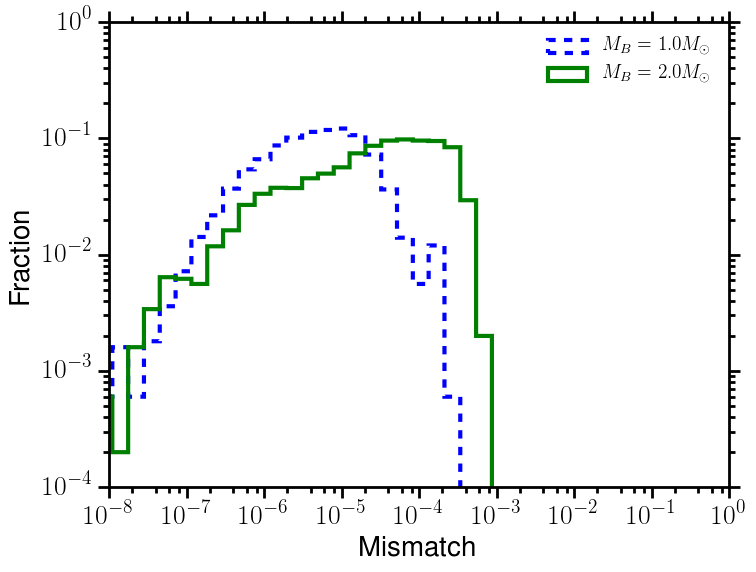

In [54]:
Nsamp = len(params_mm_10)
print Nsamp

fig, axes = plt.subplots(1, figsize=(8, 6))

axes.hist(params_mm_10[:, 3], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='--', lw=3, color='blue', alpha=1.0, label=r'$M_B=1.0M_\odot$')
axes.hist(params_mm_20[:, 3], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='-', lw=3, color='green', alpha=1.0, label=r'$M_B=2.0M_\odot$')
# axes.hist(params_mm_10[:, 3], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='stepfilled', 
#           color='blue', alpha=0.5, label=r'$M_B=1.0M_\odot$')
# axes.hist(params_mm_20[:, 3], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='stepfilled', 
#           color='green', alpha=0.5, label=r'$M_B=2.0M_\odot$')
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim([1.0e-8, 1.0e-0])
#axes.set_ylim([1, 1.0e8])
axes.set_xlabel(r'Mismatch')
axes.set_ylabel(r'Fraction')
axes.legend(loc='upper right', frameon=False)
fig.savefig('/home/bdlackey/public_html/ROM/mismatchhist.pdf', format='pdf', transparent=True, bbox_inches='tight')

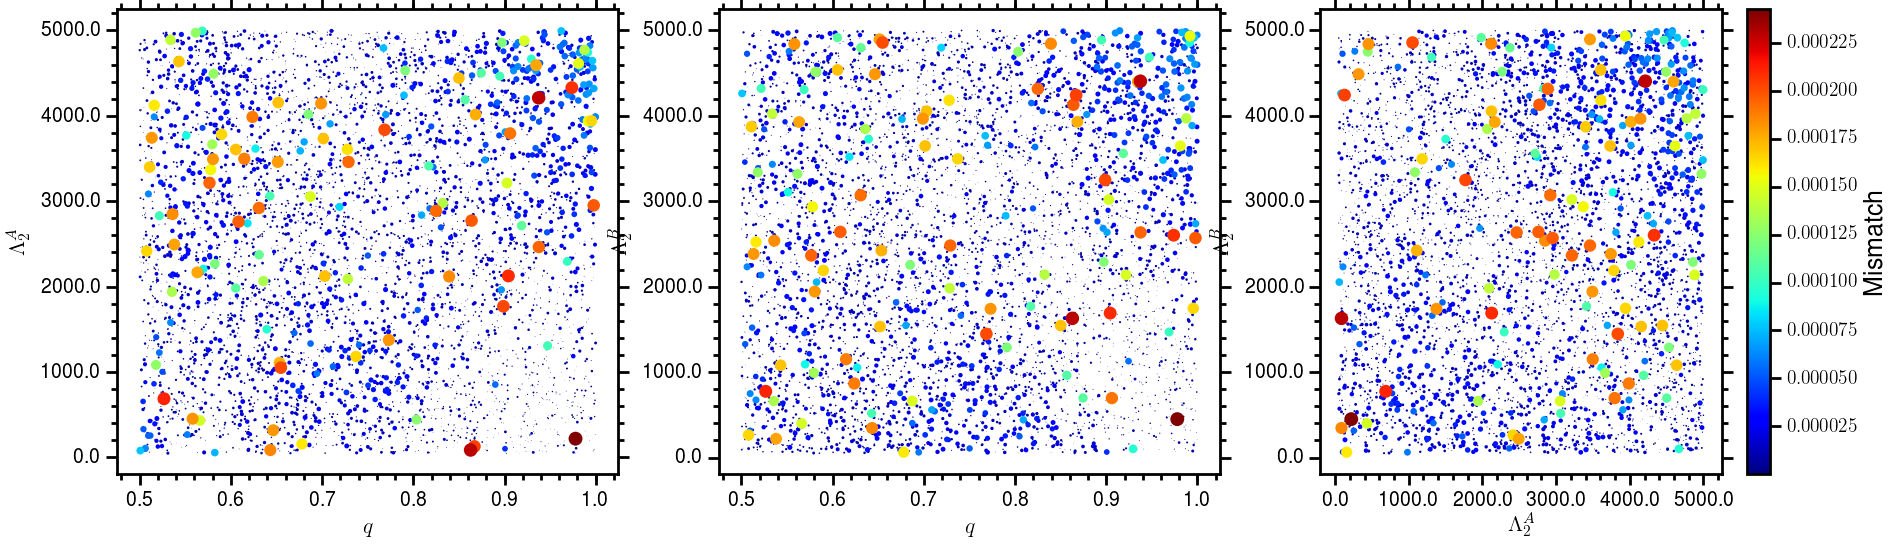

In [55]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_mm_10, params_mm_10[:, 3], 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_mm_10, params_mm_10[:, 3], 0, 2, r'$q$', r'$\Lambda_2^B$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_mm_10, params_mm_10[:, 3], 1, 2, r'$\Lambda_2^A$', r'$\Lambda_2^B$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'Mismatch')

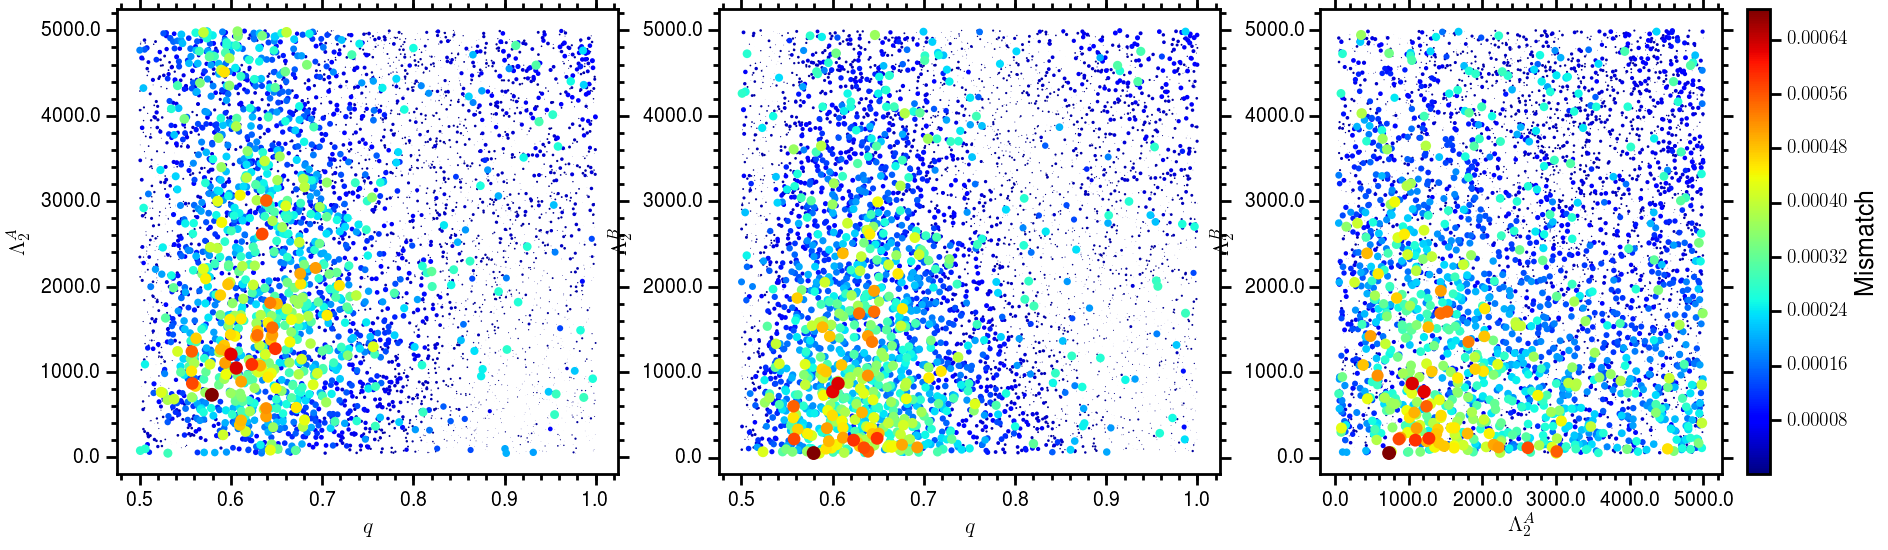

In [56]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(22, 6))

axes = fig.add_subplot(131)
diagnostics.max_error_2d_projection_plot(axes, params_mm_20, params_mm_20[:, 3], 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None)

axes = fig.add_subplot(132)
diagnostics.max_error_2d_projection_plot(axes, params_mm_20, params_mm_20[:, 3], 0, 2, r'$q$', r'$\Lambda_2^B$', rb_params_list=None)

axes = fig.add_subplot(133)
diagnostics.max_error_2d_projection_plot(axes, params_mm_20, params_mm_20[:, 3], 1, 2, r'$\Lambda_2^A$', r'$\Lambda_2^B$', rb_params_list=None,
                             colorbar=True, colorbarlabel=r'Mismatch')

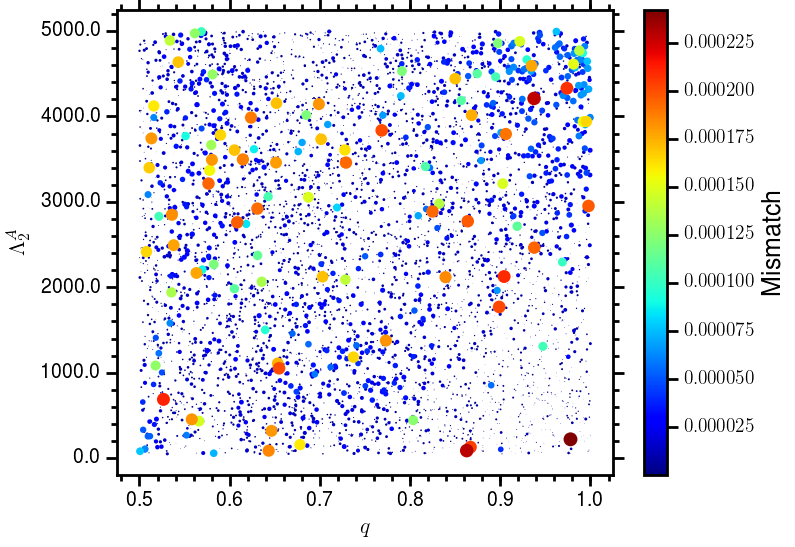

In [57]:
# Amplitude errors of reduced basis waveform
fig = plt.figure(figsize=(8, 6))

axes = fig.add_subplot(111)
diagnostics.max_error_2d_projection_plot(axes, params_mm_10, params_mm_10[:, 3], 0, 1, r'$q$', r'$\Lambda_2^A$', rb_params_list=None,
                                         colorbar=True, colorbarlabel=r'Mismatch')

#fig.savefig('/home/bdlackey/public_html/ROM/mismatch.pdf', format='pdf', transparent=True, bbox_inches='tight')